In [ ]:
!pip install evaluate bert_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
predictions_file = "/content/drive/MyDrive/search/videoQA/predictions.jsonl"
references_file = "/content/drive/MyDrive/search/videoQA/references.jsonl"

In [5]:
import json

def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():  # 空行を無視
                data.append(json.loads(line))
    return data

In [6]:
predictions_data = load_jsonl(predictions_file)
references_data = load_jsonl(references_file)
predictions_answers = [item['answer'] for item in predictions_data]
references_answers = [item['answer'] for item in references_data]

In [7]:
# structure
predictions_data[0]

{'video_id': '0001',
 'qa_id': '01',
 'question': 'Why did protesters play drums after receiving a police warning?',
 'answer': 'They drummed in response to a call to resist.',
 'span': ['[14.516, 18.381]', '[89.758, 103.396]', '[103.437, 112.57]'],
 'hot_vector': [0, 1, 0, 0, 0, 1, 1]}

In [ ]:
from evaluate import load

bertscore = load("bertscore")
results = bertscore.compute(predictions=predictions_answers, references=references_answers, lang="en")

print(results)

In [9]:
import pandas as pd

df = pd.DataFrame({
    "precision": results["precision"],
    "recall": results["recall"],
    "f1": results["f1"],
})

df

,precision,recall,f1
0,0.901324,0.901455,0.901390
1,0.889291,0.895154,0.892213
2,0.878538,0.877458,0.877997
3,0.919599,0.916522,0.918058
4,0.965410,0.963316,0.964362
5,0.881042,0.897565,0.889227
6,0.900680,0.886790,0.893681
7,0.978862,0.990945,0.984866
8,0.912102,0.891297,0.901580
9,0.974328,0.976743,0.975534


In [10]:
print("Average BERTScores:")
print(f"Precision: {df['precision'].mean():.3f}")
print(f"Recall:    {df['recall'].mean():.3f}")

Average BERTScores:
Precision: 0.904
Recall:    0.909


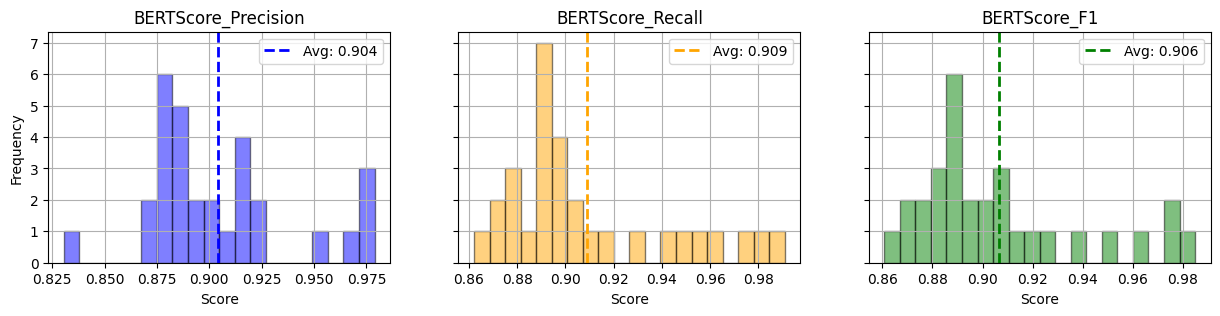

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 平均値
mean_precision = np.mean(results["precision"])
mean_recall = np.mean(results["recall"])
mean_f1 = np.mean(results["f1"])

# サブプロット作成（1行3列）
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)

# Precision
axes[0].hist(results["precision"], bins=20, alpha=0.5, color='blue', edgecolor='black')
axes[0].axvline(mean_precision, color='blue', linestyle='dashed', linewidth=2, label=f'Avg: {mean_precision:.3f}')
axes[0].set_title("BERTScore_Precision")
axes[0].set_xlabel("Score")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# Recall
axes[1].hist(results["recall"], bins=20, alpha=0.5, color='orange', edgecolor='black')
axes[1].axvline(mean_recall, color='orange', linestyle='dashed', linewidth=2, label=f'Avg: {mean_recall:.3f}')
axes[1].set_title("BERTScore_Recall")
axes[1].set_xlabel("Score")
axes[1].legend()
axes[1].grid(True)

# F1
axes[2].hist(results["f1"], bins=20, alpha=0.5, color='green', edgecolor='black')
axes[2].axvline(mean_f1, color='green', linestyle='dashed', linewidth=2, label=f'Avg: {mean_f1:.3f}')
axes[2].set_title("BERTScore_F1")
axes[2].set_xlabel("Score")
axes[2].legend()
axes[2].grid(True)




##根拠となるイベントの選択部分



In [12]:
# structure
predictions_data[0]

{'video_id': '0001',
 'qa_id': '01',
 'question': 'Why did protesters play drums after receiving a police warning?',
 'answer': 'They drummed in response to a call to resist.',
 'span': ['[14.516, 18.381]', '[89.758, 103.396]', '[103.437, 112.57]'],
 'hot_vector': [0, 1, 0, 0, 0, 1, 1]}

In [13]:
def calc_metrics(pred, ref):
    assert len(pred) == len(ref), "Input lists must have the same length."

    tp = sum(p == 1 and r == 1 for p, r in zip(pred, ref))
    fp = sum(p == 1 and r == 0 for p, r in zip(pred, ref))
    fn = sum(p == 0 and r == 1 for p, r in zip(pred, ref))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return precision, recall, f1

In [14]:
metrics_per_sample = []
for pred, ref in zip(predictions_data, references_data):
    p, r, f1 = calc_metrics(pred["hot_vector"], ref["hot_vector"])
    metrics_per_sample.append((p, r, f1))

avg_precision = sum(m[0] for m in metrics_per_sample) / len(metrics_per_sample)
avg_recall = sum(m[1] for m in metrics_per_sample) / len(metrics_per_sample)

print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall:    {avg_recall:.3f}")

Average Precision: 0.589
Average Recall:    0.547


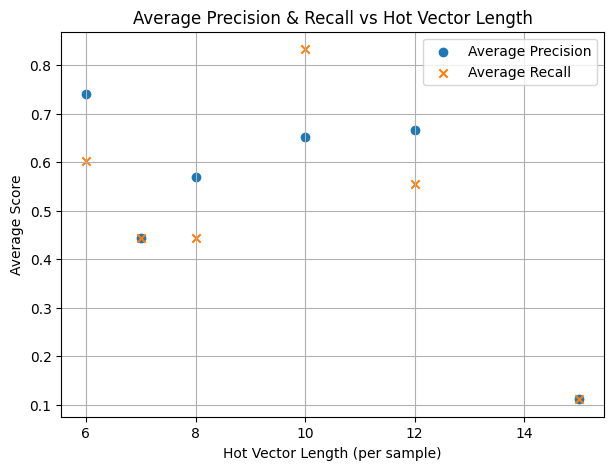

In [15]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# 長さごとに precision と recall を格納する辞書
metrics_by_length = defaultdict(lambda: {"precision": [], "recall": []})

for pred, ref in zip(predictions_data, references_data):
    p, r, f1 = calc_metrics(pred["hot_vector"], ref["hot_vector"])
    length = len(pred["hot_vector"])
    metrics_by_length[length]["precision"].append(p)
    metrics_by_length[length]["recall"].append(r)

# 長さの昇順に並べる
lengths = sorted(metrics_by_length.keys())

avg_precisions = [np.mean(metrics_by_length[l]["precision"]) for l in lengths]
avg_recalls = [np.mean(metrics_by_length[l]["recall"]) for l in lengths]

plt.figure(figsize=(7, 5))
plt.scatter(lengths, avg_precisions, marker='o', label="Average Precision")
plt.scatter(lengths, avg_recalls, marker='x', label="Average Recall")
plt.xlabel("Hot Vector Length (per sample)")
plt.ylabel("Average Score")
plt.title("Average Precision & Recall vs Hot Vector Length")
plt.legend()
plt.grid(True)
plt.show()